# Netflix Recommender System - (Draft2)

<u>Summary of all the steps done in this notebook:</u>
- directories for datasets have been set
- dataset file names have been stored in different variables


<u>For IMDB Work:</u>
- Data Dictionary for IMDB datafile: https://www.imdb.com/interfaces/
- Location for IMDB datafiles: https://datasets.imdbws.com/
- "\N" represents missing or null values in IMDB datasets. These have been replaced with np.nan


<p>since the "\\" denotes escape character, regex has been applied to avoid the below error: 
    
<b>SyntaxError:</b> (unicode error) 'unicodeescape' codec can't decode bytes in position 0-1: malformed \N character escape
</p>
    

<font color = "blue"> This color sentence indicates I am trying to talk to you! Mike and Vivek</font>    

### Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import re

from cycler import cycler

%matplotlib inline

### Set default options

In [2]:
pd.options.display.max_colwidth = 100
plt.style.use('dark_background')
plt.rcParams["axes.prop_cycle"] = cycler('color', ["#f50000", "#f00000", "#e60000", "#e00000", "#db0000", "#d10000", 
                                                   "#cc0000", "#c70000", "#bd0000", "#b80000", "#b30000", "#a80000", 
                                                   "#a30000", "#9e0000", "#940000"])
plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.size"] = 14
plt.rcParams["font.weight"] = "ultralight"

In [3]:
# plt.rcParams

In [4]:
# directory that contains netflix dataset
net_dir = os.getcwd() + "\\Netflix_Dataset\\"

# zip file containing netflix dataset
net_zipfile = "Netflix_Titles.zip"

# Read the file and save in raw dataframe
netflix_raw_data = pd.read_csv(net_dir + net_zipfile)

In [5]:
# info and describe raw dataframe
netflix_raw_data.info()
netflix_raw_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


,release_year
count,7787.000000
mean,2013.932580
std,8.757395
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2018.000000
max,2021.000000


In [6]:
# check for any duplicate records
print("No. of duplicated records (if any):", netflix_raw_data.duplicated().sum())

No. of duplicated records (if any): 0


In [7]:
# content category
netflix_raw_data["type"].value_counts()

Movie      5377
TV Show    2410
Name: type, dtype: int64

In [8]:
# sample rows from netflix dataset
netflix_raw_data.tail(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7784,s7785,Movie,Zulu Man in Japan,NaN,Nasty C,NaN,"September 25, 2020",2019,TV-MA,44 min,"Documentaries, International Movies, Music & Musicals","In this documentary, South African rapper Nasty C hits the stage and streets of Tokyo, introduci..."
7785,s7786,TV Show,Zumbo's Just Desserts,NaN,"Adriano Zumbo, Rachel Khoo",Australia,"October 31, 2020",2019,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the next “Willy Wonka” in this tense competition that fin...
7786,s7787,Movie,ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS,Sam Dunn,NaN,"United Kingdom, Canada, United States","March 1, 2020",2019,TV-MA,90 min,"Documentaries, Music & Musicals",This documentary delves into the mystique behind the blues-rock trio and explores how the enigma...


In [9]:
# this block of code only displays columns which have missing data and the % of rows with the missing values
null_column_list = []

# total no. of rows in dataset
total_rows = netflix_raw_data.shape[0]

for each_col in netflix_raw_data.columns:
    if netflix_raw_data[each_col].isnull().sum() > 0:
        null_sum = netflix_raw_data[each_col].isnull().sum()
        null_perc = "{:.4f}".format(null_sum / total_rows * 100)
        
        null_column_list.append([each_col, null_sum, null_perc])
        
# delete the dummy variable        
del total_rows
        
# display missing row count and % as a dataframe    
pd.DataFrame(null_column_list, columns = ["Column Name", "No. of rows with missing values", 
                                          "Missing value as % (Netflix Dataset)"])

,Column Name,No. of rows with missing values,Missing value as % (Netflix Dataset)
0,director,2389,30.6793
1,cast,718,9.2205
2,country,507,6.5109
3,date_added,10,0.1284
4,rating,7,0.0899


For the date_added column, we can't be sure as to when exactly the show was added to Netflix, so we will simply remove these records. 

Since the rating column has only 7 values missing, let's identify these titles and try to fill-up the rating column with the help of IMDB. Ofcourse this process is manual.

## Explore Netflix Dataset

### type Column

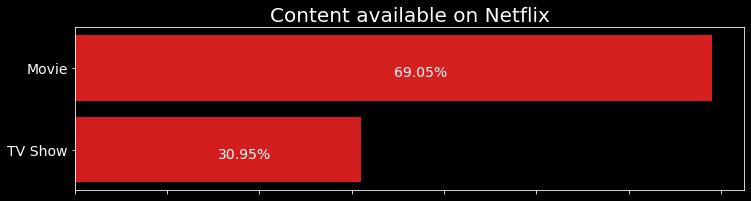

In [10]:
fig,ax = plt.subplots(figsize = (12,3))

# plot content type as percentage
sns.barplot(y = netflix_raw_data["type"].value_counts(normalize = True).index,
            x = netflix_raw_data["type"].value_counts(normalize = True).mul(100).values, 
            ax = ax)

ax.set_title("Content available on Netflix")
ax.set_xticklabels("")

# annotate each bar
for p in ax.patches:
    ax.annotate("{:.2f}%".format(p.get_width()), [p.get_width()/ 2, p.get_y() + 0.5])
    
plt.show()    

### rating Column

In [11]:
# identify the titles with missing-values
netflix_raw_data.loc[netflix_raw_data["rating"].isnull(), ["title", "director", "release_year", "rating"]]

,title,director,release_year,rating
67,13TH: A Conversation with Oprah Winfrey & Ava DuVernay,NaN,2017,NaN
2359,Gargantia on the Verdurous Planet,NaN,2013,NaN
3660,Little Lunch,NaN,2015,NaN
3736,Louis C.K. 2017,Louis C.K.,2017,NaN
3737,Louis C.K.: Hilarious,Louis C.K.,2010,NaN
3738,Louis C.K.: Live at the Comedy Store,Louis C.K.,2015,NaN
4323,My Honor Was Loyalty,Alessandro Pepe,2015,NaN


In [12]:
# dictionary to map title with ratings (Copied from Mike's work)
ratings_map = {idx:val for idx,val in zip(netflix_raw_data.loc[netflix_raw_data["rating"].isnull(), "title"].values, 
                                          ["TV-PG", "TV-14", "TV-Y7", "TV-MA", "TV-MA", "TV-MA", "PG-13"])}
# display ratings dictionary
ratings_map

{'13TH: A Conversation with Oprah Winfrey & Ava DuVernay': 'TV-PG',
 'Gargantia on the Verdurous Planet': 'TV-14',
 'Little Lunch': 'TV-Y7',
 'Louis C.K. 2017': 'TV-MA',
 'Louis C.K.: Hilarious': 'TV-MA',
 'Louis C.K.: Live at the Comedy Store': 'TV-MA',
 'My Honor Was Loyalty': 'PG-13'}

In [13]:
# replace the missing ratings
netflix_raw_data["rating"] = netflix_raw_data["title"].map(ratings_map).fillna(netflix_raw_data["rating"])

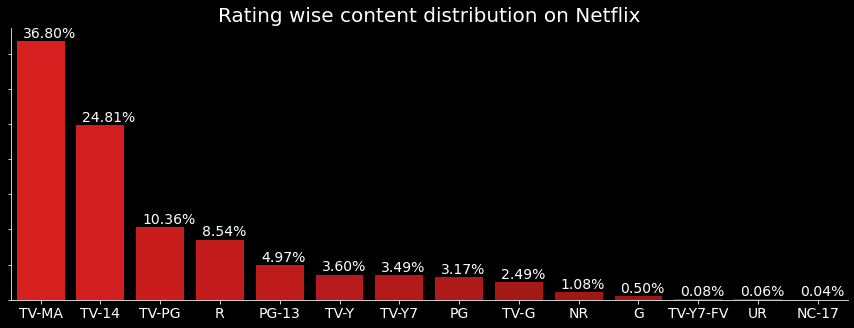

In [14]:
fig, ax = plt.subplots() # figsize = (15, 5))

# plot distribution of titles as % based on the rating column
sns.barplot(x = netflix_raw_data["rating"].value_counts(normalize = True).index,
            y = netflix_raw_data["rating"].value_counts(normalize = True).mul(100).values, 
            ax = ax)

ax.set_title("Rating wise content distribution on Netflix")
ax.set_yticklabels("")

for p in ax.patches:
    ax.annotate("{:.2f}%".format(p.get_height()), [p.get_x() + 0.1, p.get_height() + 0.5],)

sns.despine()
plt.show()

### date_added Column & release Column

- The format in netflix dataset for this column is "Month Day, Year" and is of object dtype. We will first change this to pandas datetime format
- Also, since the column has 10 missing values, we will remove those rows

- Can't really trust the release year column since if a title has been running for multiple seasons, netflix dataset may only have the most recent release year

In [15]:
from datetime import datetime as dt

In [16]:
# convert to datetime format
netflix_raw_data["date_added"] = pd.to_datetime(netflix_raw_data["date_added"])

# select only those records where date_added column has values
netflix_raw_data = netflix_raw_data[netflix_raw_data["date_added"].notna()]

# shape of resultant netflix_raw_data
netflix_raw_data.shape

(7777, 12)

#### Additional Analysis

This is a small analysis of:
- distribution of titles based on the decade they were released
- distribution of titles hosted by Netflix since it's inception

For ease of plotting:
- the titles that were released before the year 1980, have been grouped under `Before 1980`. Why this year? because I was born in this decade!
- since Netflix established itself in 190 countries by 2016, all the titles added (on Netflix platform) before 2016 have been grouped under `Added before 2016`.

Tried this analysis with two charts - Pie and Line.

In [17]:
# calculate the decade for each year of release
decade_df = (netflix_raw_data["release_year"] // 10 * 10).value_counts().reset_index()

# rename the dataframe columns
decade_df.rename(columns = {"index": "Decade", "release_year" : "No. of Titles"}, inplace = True)

# identify titles released before the year 1980 
decade_df["Decade"] = decade_df["Decade"].apply(lambda d: d if d > 1980 else "Before 1980")

# label each decade as YYYY's
decade_df["Decade"] = decade_df["Decade"].astype(str).apply(lambda s: s + "'s")

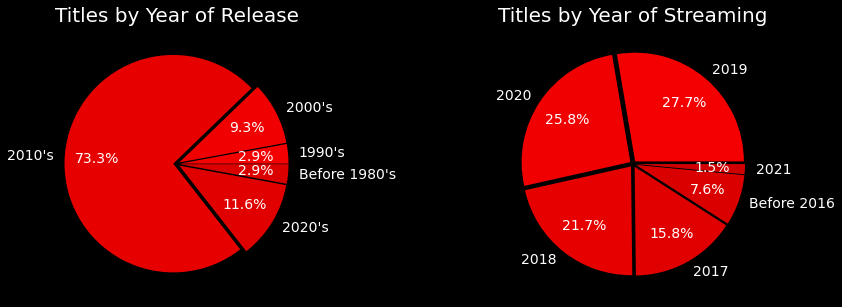

In [18]:
fig, ax = plt.subplots(figsize = (15, 5), ncols = 2)

# group the no. of titles by decade in which they were released
data = decade_df.groupby("Decade")["No. of Titles"].sum()

# plot the years when title was released
ax[0].pie(x = data.values, 
          labels = data.index,
          autopct = "%.1f%%",
          explode = [0.03] * len(data),
          pctdistance = 0.7)
ax[0].set_title("Titles by Year of Release")

# group the no. of titles by decade in which they were added to Netflix
data = netflix_raw_data["date_added"].dt.year.apply(lambda d: d if d > 2016 else "Before 2016").value_counts()

# plot the years when title was added
ax[1].pie(x = data.values,
          labels = data.index,
          autopct = "%.1f%%",
          explode = [0.03] * len(data),
          pctdistance = 0.7)
ax[1].set_title("Titles by Year of Streaming")

plt.show()

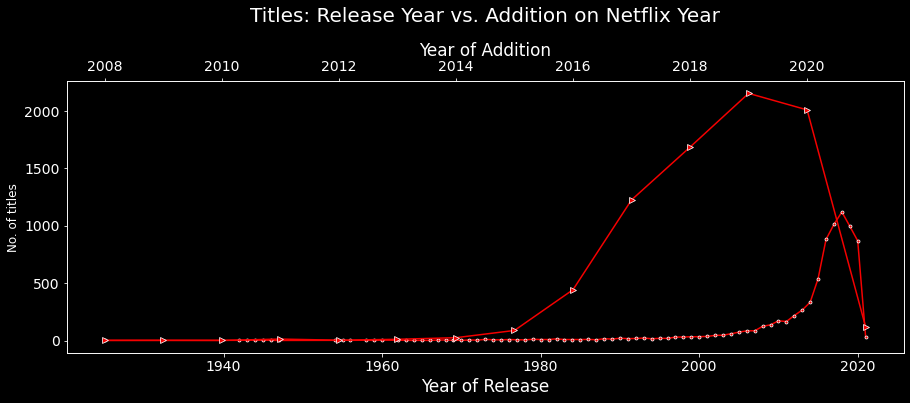

In [19]:
# Compare release year and the year title was added to Netflix

# release year plot
sns.lineplot(data = netflix_raw_data["release_year"].value_counts(),
                marker = ".")
plt.xlabel("Year of Release", fontsize = "large")
plt.ylabel("No. of titles")

# twin the first plot 
plt.twiny()

# plot for year of addition of title
sns.lineplot(data = netflix_raw_data["date_added"].dt.year.value_counts(),
                marker = ">")
plt.xlabel("Year of Addition", fontsize = "large")

# extras
plt.title("Titles: Release Year vs. Addition on Netflix Year", pad = 20)
plt.show()

### duration Column

This column specifies the duration of a title in No. of seasons or runtime in minutes. However, if we analyze the values, the TV Shows are specified with seasons and Movies have runtime minutes. No series has runtime in minutes.

In [20]:
# title type with duration in seasons
print(netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("Season"), "type"].value_counts(), "\n")

# title type with duration in minutes
print(netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("min"), "type"].value_counts())

TV Show    2400
Name: type, dtype: int64 

Movie    5377
Name: type, dtype: int64


In [21]:
# duration for title type TV Show 
netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("Season"), "duration"].value_counts()

1 Season      1608
2 Seasons      378
3 Seasons      183
4 Seasons       86
5 Seasons       57
6 Seasons       30
7 Seasons       19
8 Seasons       18
9 Seasons        8
10 Seasons       5
12 Seasons       2
15 Seasons       2
11 Seasons       2
13 Seasons       1
16 Seasons       1
Name: duration, dtype: int64

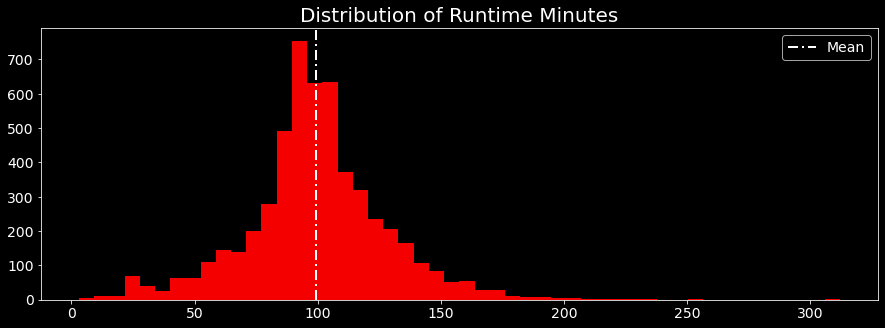

In [22]:
# distribution of runtime in minutes
plt.hist(x = netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("min"), "duration"].\
         str.strip("min").astype(int), 
         bins = 50)
plt.axvline(x = netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("min"), "duration"].\
            str.strip("min").astype(int).mean(),
            lw = 2,
            dashes = [5, 2, 1, 2],
            color = "white", 
            label = "Mean")
plt.legend()
plt.title("Distribution of Runtime Minutes")
plt.show()

# netflix_raw_data.loc[netflix_raw_data["duration"].str.contains("min"), "duration"].str.strip("min").astype(int).mean()

### Section for listed_in Column


In [23]:
# listed_in sample values

## Tackle the Missing Values

<font color = "blue">Okay I tried on this and yes Even I am disappinted with the progress I have made. And apparently it seems I won't last 1 day of employment itself based on these results !</font>

The big bad boy: Missing Values in 3 columns - Director, Cast and Country of origin of a title. 
The idea is to try out the best approach and fill-in as many missing values as we can.

So how exactly are we going to achieve this?

- IMDB provides separate datasets with different information. The common link between these datasets are alpha-numeric columns like "tconst", "nconst" etc. that identify a title or cast & crew memeber.
- The dataset name_basics provides the names of the cast and crew identifies by unique ncosnt ID

### Prepare the columns

<font color = "blue">I first split the dataset of netflix into 3 parts - one for each column. </font>

In [24]:
"""split the dataframe with missing and non-missing values"""

# non-null data
netflix_data = netflix_raw_data[(netflix_raw_data["director"].notna()) &
                                (netflix_raw_data["cast"].notna()) &
                                (netflix_raw_data["country"].notna())].reset_index(drop = True)

# where director is missing
missing_directors = netflix_raw_data[netflix_raw_data["director"].isnull()].reset_index(drop = True)

# where cast is missing
missing_cast = netflix_raw_data[netflix_raw_data["cast"].isnull()].reset_index(drop = True)

# where country is missing
missing_country = netflix_raw_data[netflix_raw_data["country"].isnull()].reset_index(drop = True)

In [25]:
# shape of resultant datasets
print("Directors :" + str(missing_directors.shape),
      "Cast :" + str(missing_cast.shape),
      "Country :" + str(missing_country.shape),
      "Non-null data :" + str(netflix_data.shape), sep = "\n")

Directors :(2379, 12)
Cast :(718, 12)
Country :(506, 12)
Non-null data :(4812, 12)


In [26]:
# combination of title and release_year columns >> missing_directors dataset
missing_directors["combo"] = missing_directors["title"].str.replace(r"[^\w\s]+", "", regex = True).str.lower().\
                             str.cat(missing_directors["release_year"].astype(str), sep = "_")

# sample rows with selected columns only 
missing_directors[["type", "title", "release_year", "combo", "director"]].head()

,type,title,release_year,combo,director
0,TV Show,3%,2020,3_2020,NaN
1,TV Show,1983,2018,1983_2018,NaN
2,TV Show,Feb-09,2018,feb09_2018,NaN
3,Movie,'89,2017,89_2017,NaN
4,TV Show,​SAINT SEIYA: Knights of the Zodiac,2020,saint seiya knights of the zodiac_2020,NaN


In [27]:
# combination of title and release_year columns >> missing_cast dataset
missing_cast["combo"] = missing_cast["title"].str.replace(r"[^\w\s]+", "", regex = True).str.lower().\
                             str.cat(missing_cast["release_year"].astype(str), sep = "_")

# sample rows with selected columns only
missing_cast[["type", "title", "release_year", "combo", "cast"]].head()

,type,title,release_year,combo,cast
0,TV Show,1994,2019,1994_2019,NaN
1,Movie,(T)ERROR,2015,terror_2015,NaN
2,TV Show,(Un)Well,2020,unwell_2020,NaN
3,Movie,#cats_the_mewvie,2020,cats_the_mewvie_2020,NaN
4,Movie,#Rucker50,2016,rucker50_2016,NaN


### Set-up to read IMDB datasets

<font color = "blue"> Here I created a .py file so that reading of IMDB datasets is done over there. The idea was to dump any messy work over there, but I still ended up creating a mess here itself. </font>

In [28]:
# Set-up directory and Files
imdb_dir = os.getcwd() + "\\IMDB_Dataset\\"
imdb_file_names = ["title_akas.tsv", "title_basics.tsv", "title_crew.tsv", "title_principals.tsv", "name_basics.tsv"]

In [29]:
# import the IMDB_work.py module aliased as "iw" for now
import IMDB_work as iw

In [30]:
"""Test code cell"""
print("Test Code For Docstring", "\n")
print(iw.__doc__)
print(iw.read_imdb_files.__doc__)

Test Code For Docstring 

python module to work with IMDB Data Files 

Function to read the ".tsv" files downloaded from IMDB interface
----------------------------------------------------------------
Name: read_imdb_files

Parameters: 
- file_name: name of the IMDB dataset file. 
- file_directory: name of the directory that contains the IMDB dataset files. Parameter has been set to default option.

Returns: a dataframe containing all the records of the IMDB dataset file with every column stored as "object" dtype

Additional Info: 
- all the fields are stored as object dtype to avoid any errors 
- prints the shape and missing value % for the datafile
    


<font color = "blue">Here we read the IMDB file containing the title and year values to match with netflix missing datasets. We also read the IMDB file containing names of all the people involved in a project. 
</font>

In [31]:
""" Read the title_basics.tsv file """
title_basics = iw.read_imdb_files(file_name = imdb_file_names[1], file_directory = imdb_dir)

The data file title_basics.tsv contains 7918519 rows and 9 columns
       ColumnName  MissingValue%
0          tconst           0.00
1       titleType           0.00
2    primaryTitle           0.00
3   originalTitle           0.00
4         isAdult           0.00
5       startYear          10.95
6         endYear          99.03
7  runtimeMinutes          72.08
8          genres           7.81


In [32]:
""" Read the name_basics.tsv file """
name_basics = iw.read_imdb_files(file_name = imdb_file_names[-1], file_directory = imdb_dir)

The data file name_basics.tsv contains 10942043 rows and 6 columns
          ColumnName  MissingValue%
0             nconst           0.00
1        primaryName           0.00
2          birthYear          95.19
3          deathYear          98.27
4  primaryProfession          21.23
5     knownForTitles          18.52


To compare title_basics dataset and missing_\<datasets\>: 
    
- both the title and primaryTitle columns have been stripped of any non alpha-numeric characters
- the titles have been set to lower case
- release_year and startYear columns have been appended to the title name columns respectively

In [33]:
# combination of primaryTitle and startYear columns >> title_basics dataset
title_basics["combo"] = title_basics["primaryTitle"].str.replace(r"[^\w\s]+", "", regex = True).str.lower().\
                        str.cat(title_basics["startYear"].astype(str), sep = "_")

### Finding Missing Directors

In [34]:
# match the combination in title_basics and missing_directors dataframes
# collect and store the matched records in a temporary dataframe - match_df 

match_df = title_basics.loc[title_basics["combo"].isin(missing_directors["combo"]), 
                            ["tconst", "combo"]].reset_index(drop = True).groupby("combo")["tconst"].unique().reset_index()

# sample rows from resultant match_df dataframe
match_df.head()

,combo,tconst
0,100 days my prince_2018,[tt8199972]
1,100 things to do before high school_2014,"[tt3904078, tt3914888]"
2,12 years promise_2014,[tt5476252]
3,13 reasons why_2020,[tt12301534]
4,13th a conversation with oprah winfrey ava duvernay_2017,[tt6491068]


<font color = "blue"> Okay here I thought of possible combinations to clarify between the titles which have similar/ same names but were released in different years. But then this data clean-up itself is one big project as Mike also told me but I kind of was relunctant to listen! Lesson learned at Mike's & Vivek's time expense..... So for now I filtered the title which have unique names. 

In [35]:
# filter out unique title names i.e. no other title of the same name was released at any other time
match_df = match_df[match_df["tconst"].str.len() == 1].set_index("combo").explode("tconst").reset_index()

In [36]:
match_df.shape

(1064, 2)

In [37]:
""" Read the title_crew.tsv file """
title_crew = iw.read_imdb_files(file_name = imdb_file_names[2], file_directory = imdb_dir)

The data file title_crew.tsv contains 7918519 rows and 3 columns
  ColumnName  MissingValue%
0     tconst           0.00
1  directors          42.42
2    writers          49.18


In [38]:
"""
- match the tconst ID between the match_df and title_crew dataset
- extract director ID's associated with a title from title_crew dataframe
"""

# match the title ID and map the director ID in match_df dataframe
match_df["director_id"] = match_df["tconst"].map(dict(title_crew.loc[title_crew["tconst"].isin(match_df["tconst"]), 
                                                                     ["tconst", "directors"]].dropna().values))

"""since the title_crew dataset itself has null values these matches are of no use to us
so we drop the records where director ID's are still null"""

# drop null values
match_df.dropna(inplace = True)

# reset the index for match_df to linear >> 0,...,n-1
match_df.reset_index(drop = True, inplace = True)

In [39]:
"""Since we collected multiple directors as comma separated values 
we will explode these ID's so that we get one director ID per row."""

# split the director ID by ","
match_df["director_id"] = match_df["director_id"].str.split(",")

# explode on director ID column to get dataframe with each in separate row
match_df = match_df.set_index(["combo", "tconst"]).explode("director_id").reset_index()

In [40]:
"""Match the director ID with nconst column in Name Basics dataset and extract the name of the director"""

# match the director ID and nconst columns
matched_names = name_basics.loc[name_basics["nconst"].isin(match_df["director_id"]), ["nconst", "primaryName"]].values

# map the names of directors
match_df["director_name"] = match_df["director_id"].map(dict(matched_names))

This is a reverse process to short our long dataframe into a wide one by grouping (multiple if present) director(s) based on a title.

In [41]:
# group the directors by title ID
match_df = match_df.groupby("combo")["director_name"].apply(lambda s: ",".join(s)).reset_index()

In [42]:
# How many missing directors have we been able to identify?
match_df.shape

(857, 2)

In [43]:
# replace the missing_directors; this will be later appended to netflix non null dataset
missing_directors["director"] = missing_directors["combo"].map(dict(match_df.values)).fillna("Unknown")

### Finding Missing Cast

<font color = "blue">The process employed for directors has been replicated for Cast members as well, much to a very very very disappointing result</font>

In [44]:
# match the combination in title_basics and missing_cast dataframes
# collect and store the matched records in a temporary dataframe - match_df 

match_df = title_basics.loc[title_basics["combo"].isin(missing_cast["combo"]), 
                            ["tconst", "combo"]].reset_index(drop = True).groupby("combo")["tconst"].unique().reset_index()

# shape of match_df dataframe
print(match_df.shape)

# samle rows from match_df
match_df.head()

(518, 2)


,combo,tconst
0,13th_2016,[tt5895028]
1,14 minutes from earth_2016,[tt5626716]
2,1994_2019,"[tt10243640, tt11974294, tt13229100, tt8736278]"
3,3 seconds divorce_2018,[tt7987516]
4,7 days out_2018,[tt9315990]


In [45]:
# filter out unique title names i.e. no other title of the same name was released at any other time
match_df = match_df[match_df["tconst"].str.len() == 1].set_index("combo").explode("tconst").reset_index()

In [46]:
# resultant match_df shape with unique title names
match_df.shape

(440, 2)

In [47]:
"""Read title_principals.tsv file"""
title_principals = iw.read_imdb_files(file_name = imdb_file_names[3], file_directory = imdb_dir)

The data file title_principals.tsv contains 44887359 rows and 6 columns
   ColumnName  MissingValue%
0      tconst           0.00
1    ordering           0.00
2      nconst           0.00
3    category           0.00
4         job          83.90
5  characters          49.97


In [48]:
# Value present in category column 
sorted(title_principals["category"].unique())

['actor',
 'actress',
 'archive_footage',
 'archive_sound',
 'cinematographer',
 'composer',
 'director',
 'editor',
 'producer',
 'production_designer',
 'self',
 'writer']

In [49]:
"""
- match the tconst ID between the match_df and title_principals dataset
- extract director ID's associated with a title from title_principals dataframe 
- select only those principals where category is Actor or Actress
"""

match_df["cast_id"] = (
    match_df["tconst"].map(dict(title_principals.loc[(title_principals["tconst"].isin(match_df["tconst"])) &
                                                     (title_principals["category"].isin(["actress", "actor"])), 
                                                     ["tconst", "nconst"]].reset_index(drop = True).\
                                groupby("tconst")["nconst"].unique().reset_index().values))
)

# drop null values
match_df.dropna(inplace = True)

# reset index of match_df dataframe
match_df.reset_index(drop = True, inplace = True)

In [50]:
# explode match_df on cast_id column to get one principal ID per row
match_df = match_df.set_index(["combo", "tconst"]).explode("cast_id").reset_index()

In [51]:
# match the cast ID with nconst column
matched_names = name_basics.loc[name_basics["nconst"].isin(match_df["cast_id"]), ["nconst", "primaryName"]].values

# map the Names of cast members to match_df dataframe
match_df["cast_name"] = match_df["cast_id"].map(dict(matched_names))

In [52]:
match_df.shape

(365, 4)

In [53]:
# The grouping and mapping have been done in one step for the cast members
missing_cast["cast"] = missing_cast["combo"].map(dict(match_df.groupby("combo")["cast_name"].
                                                      apply(lambda s: ",".join(s)).reset_index().values)).fillna("Unknown")

In [54]:
missing_cast[missing_cast["cast"] == "Unknown"].shape

(604, 13)

<font color = "blue"> Yeah! I know this is the disappointment.... after all that, for only 114 rows I was able to find the cast</font>

### Finding Missing Country

<font color = "blue">This is the worst of the lot..... Arghhh what was I thinking! So I guess I will completely go by Mikes' way for this column.</font>

In [55]:
pd.options.display.max_colwidth = 200

In [56]:
from bs4 import BeautifulSoup

import requests

In [57]:
# Read a page from Wikipedia which enlists the adjectivals and denonymns for countries
website = requests.get("https://en.wikipedia.org/wiki/List_of_adjectival_and_demonymic_forms_for_countries_and_nations")

# parse the htl content
soup = BeautifulSoup(website.content, 'html.parser')

In [58]:
# find all the html elements that are of type table
tables = soup.find_all('table', class_='sortable')

# We only need the table with the 3 columns - Country Name, Adjectival and Denonym
# Search among all the tables avaialable and break the loop once found
for table in tables:
    ths = table.find_all("th")
    headings = [th.text.strip() for th in ths]
    if headings[:3] == ['Country/entity name', 'Adjectivals', 'Demonyms']:
        break

# empty dictionary to store the columns - Adjectival and Country - as Key-Value pair respectively  
country_dict = {}    

# loop through each row in table to capture country-adjectival
for tr in table.find_all("tr"):
    tds = tr.find_all("td")
    if not tds:
        continue
    # split each row into the 3 variables
    country, adjectival, denonym = [td.text.strip() for td in tds]
    
    # strip and characters/ links from country and adjectival Names
    country = re.sub(r"\[.*?\]", "", country).split(",")[0]
    adjectival = re.sub(r"\[.*?\]", "", adjectival).split(",")[0]
    
    # store the country and adjectival in dictionary 
    country_dict[adjectival] = country

In [59]:
# remove the key-value pairs that may not be required
for each in ["Antarctic", "English", "European", "North Korean", "South Korean", "South Sudanese", "Svalbard resident"]:
    country_dict.pop(each)

# Shorten the full-name of Countries to values similar to Netflix Dataset
country_dict["British"] = "United Kingdom"
country_dict["American"] = "United States"
country_dict["Korean"] = "South Korea"

<font color = "blue"> This block of code demonstrates why this idea can't/didn't work:
- There are several title with dual location words like "Age of Glory". This movie is set/created in Malaysia but has Chinese language.    
    
- Then we have some records with Latin American or Asian American key-words. But since I only included the key-value pair of American - United States, the resultant country would be so so so WRONG!
    
- Also researched out this title "Homeland". Well here's the trouble with this one: 
    - This movie has been made in France and India, but it contains Armenian and French in description column. So the loop would first replace Armenian with Armenia and French with France. 
    - In netflix dataset this title has release year as 2019 but on IMDB it is 2018. https://www.imdb.com/title/tt8010436/?ref_=tt_rvi_tt_i_5
</p>
    

In [60]:
# test work with Adjectival-Country (as key-value pair) dictionary 
sample = missing_country[["title", "description"]]

# function to find adjectival and replace with the Country Name
def test_func(in_row):
    # loop through each of the key-value pair
    for key, val in country_dict.items():
        
        # first search in description Column
        if (in_row["description"].find(key) or in_row["description"].find(val)) > 0:
            return val
        
        # else search in title Column
        elif (in_row["title"].find(key) or in_row["title"].find(val)) > 0:
            return val
        # RETURN THE COUNTRY NAME IN EITHER CASE    
    
# Save the derived results in a separate column
sample = sample.copy()
sample["derived_country"] = sample.apply(test_func, axis = 1)

# display all the rows in sample dataframe where derived_country column is not null
sample[sample["derived_country"].notnull()]

,title,description,derived_country
10,Age of Glory,"Amid the thriving nightlife of 1960s Kuala Lumpur, three Chinese friends – a showgirl, her housekeeper and a chanteuse – find love and heartbreak.",China
41,Beauty and the Bitches,Beauty pageant contestants from all over Thailand fight for the crown as they contend with drama and intrigue behind the scenes.,Thailand
47,Beyblade Burst Evolution,"Scouted by a famous Spanish club, Valt Aoi heads to Spain. With their sights on the World League, he and his teammates face the European League first.",Spain
53,Bling Empire,"Follow LA's wildly wealthy Asian and Asian American fun seekers as they go all out with fabulous parties, glamour and drama in this reality series.",United States
57,Border Patrol,This reality TV series follows the men and women of New Zealand's border patrol in their quest to keep their country safe and secure.,New Zealand
60,BREAK IT ALL: The History of Rock in Latin America,"Soda Stereo, Café Tacvba, Aterciopelados and others figure in this 50-year history of Latin American rock through dictatorships, disasters and dissent.",United States
78,Cheuk Wan-Chi: Two Night Stand,Writer and stand-up comedian Cheuk Wan-chi cracks wise at the follies of single womanhood and takes on politics in Hong Kong with nuance and flair.,Hong Kong
96,Club Friday The Series 6,"Based on a Thai radio show that gives love advice to callers, this series dramatizes stories of infidelity, love triangles, sexual identity and more.",Thailand
97,Club Friday The Series 7,More confessional tales of love and heartbreak play out in this next installment of the popular Thai TV series based on a real-life call-in radio show.,Thailand
98,Club Friday The Series 8,"The eighth installment of this popular Thai series, based on a real-life call-in radio show, dramatizes personal stories of romance and heartbreak.",Thailand


In [61]:
# pattern work to match the Step2B in Mike's Presentation
missing_country.loc[missing_country["title"].str.contains(r"\(\w+\)"), "title"]

21                                Angu Vaikuntapurathu (Malayalam)
88     ChuChuTV Bedtime Stories & Moral Stories for Kids (English)
89       ChuChuTV Bedtime Stories & Moral Stories for Kids (Hindi)
90                ChuChuTV Surprise Eggs Learning Videos (English)
91                  ChuChuTV Surprise Eggs Learning Videos (Hindi)
309                                           Oh! Baby (Malayalam)
310                                               Oh! Baby (Tamil)
375                                                 Seven (Telugu)
399                                            Thackeray (Marathi)
Name: title, dtype: object

### Following is an incomplete experimentation

<font color = "blue"> Which I realized is just too much work. </font>

In [62]:
""" Read the title_akas.tsv file """
title_akas = iw.read_imdb_files(file_name = imdb_file_names[0], file_directory = imdb_dir)

The data file title_akas.tsv contains 26326374 rows and 8 columns
        ColumnName  MissingValue%
0          titleId           0.00
1         ordering           0.00
2            title           0.00
3           region           2.37
4         language          16.80
5            types          92.16
6       attributes          99.16
7  isOriginalTitle           0.01


In [63]:
missing_country["combo"] = missing_country["title"].str.replace(r"[^\w\s]+", "", regex = True).str.lower().\
                           str.cat(missing_country["release_year"].astype(str), sep = "_")

# missing_country.head()

In [64]:
match_df = title_basics.loc[title_basics["combo"].isin(missing_country["combo"]), 
                            ["tconst", "combo"]].reset_index(drop = True).groupby("combo")["tconst"].unique().reset_index()

print(match_df.shape)

match_df.head()

(197, 2)


,combo,tconst
0,13th a conversation with oprah winfrey ava duvernay_2017,[tt6491068]
1,3 deewarein_2003,[tt0338490]
2,a go go cory carson halloween_2020,[tt13058374]
3,a trash truck christmas_2020,[tt13458584]
4,al acecho_2019,[tt11287390]


In [65]:
match_df = match_df[match_df["tconst"].str.len() == 1].set_index("combo").explode("tconst").reset_index()

match_df.shape

(155, 2)

In [66]:
match_df

,combo,tconst
0,13th a conversation with oprah winfrey ava duvernay_2017,tt6491068
1,3 deewarein_2003,tt0338490
2,a go go cory carson halloween_2020,tt13058374
3,a trash truck christmas_2020,tt13458584
4,al acecho_2019,tt11287390
...,...,...
150,westside vs the world_2019,tt10876506
151,whitney cummings can i touch it_2019,tt10521638
152,wish upon a unicorn_2020,tt10798660
153,wish you_2021,tt13866142


In [67]:
title_akas.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,NaN,imdbDisplay,NaN,0
1,tt0000001,2,Carmencita,DE,NaN,NaN,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,NaN,imdbDisplay,NaN,0
3,tt0000001,4,Καρμενσίτα,GR,NaN,imdbDisplay,NaN,0
4,tt0000001,5,Карменсита,RU,NaN,imdbDisplay,NaN,0


In [68]:
netflix_raw_data[netflix_raw_data["title"].str.lower() == "homeland"]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
2790,s2791,Movie,Homeland,Anindya Chatterjee,"Parambrata Chatterjee, Ani Hovhannisyan, Jonathan Dumontier, Varzu, Sylvie de Neef, Prakashchandra Roy, Nicolas Pierson, Anahit Simonyan",NaN,2019-10-15,2019,TV-PG,73 min,"Dramas, Independent Movies, International Movies","Determined to trace her ancestral history, an Armenian woman travels to a French village, where she befriends a kind man and, better yet, finds herself."
